In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import sklearn
print(sklearn.__version__)
from fastai.tabular import *
from sklearn.metrics import f1_score


0.20.3


In [29]:
defaults.device = torch.device('cuda')

In [2]:
with open("english10000.txt",'r') as f:
    words = f.read().split("\n")

In [3]:
words[0:5]

['the', 'of', 'and', 'to', 'a']

In [4]:
wordset = set(words)

In [79]:
indexdict = {None: 0}
for i,w in enumerate(words):
    indexdict[w] = i

In [80]:
indexdict['center']

215

In [81]:
def get_distribution(txt):
    txtwords = txt.lower().split()
    dist = [0]*(len(words))
    for w in txtwords:
        if w in wordset:
            dist[indexdict[w]] += 1
    tot = sum(dist)
    return [d/tot for d in dist]

In [82]:
get_distribution("The of and to a adssssssssssssssss a")[0:10]

[0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.3333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [83]:
mbti = pd.read_csv("kaggle/mbti.csv")
mbti.head()

,type,posts
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw|||h...
1,ENTP,I'm finding the lack of me in these posts very...
2,INTP,Good one _____ https://www.youtube.com/watc...
3,INTJ,"Dear , I enjoyed our conversation the other ..."
4,ENTJ,You're fired.|||That's another silly misconcep...


In [10]:
mbti.columns

Index(['type', 'posts'], dtype='object')

In [84]:
X = np.array([get_distribution(p) for p in mbti['posts']])

In [85]:
Y = np.array(mbti['type'])

In [127]:
rf = RandomForestClassifier(n_estimators=90)

In [128]:
rf.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [129]:
joblib.dump(rf,"rf.pkl")

['rf.pkl']

In [130]:
rf.predict([get_distribution("Hello World")])

array(['INFP'], dtype=object)

In [133]:
txt = """

Deep Learning Course Forums

Problem creating custom loss function
fastai users
 
 
turntwo463
David
Mar 12
I am trying to create and use a custom loss function. When my initial attempts failed I decided to take a step back and implement (through cut and paste) the standard loss function used with a unet Learner in my own notebook. I thought this would be a good way to check my understanding of the size of the tensor inputs and see where the inputs differed between the standard loss function and the ones I first created.

To my disappointment my “cut and paste” loss function also does not work in that an exception is thrown during lr_find.

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py in nll_loss(input, target, weight, size_average, ignore_index, reduce, reduction)
   1786     if input.size(0) != target.size(0):
   1787         raise ValueError('Expected input batch_size ({}) to match target batch_size ({}).'
-> 1788                          .format(input.size(0), target.size(0)))
   1789     if dim == 2:
   1790         ret = torch._C._nn.nll_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index)

ValueError: Expected input batch_size (65536) to match target batch_size (8192).
I would appreciate some insight into what I am doing wrong.

Initial standard fastai code which does work:

wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=[], wd=wd)
print('Loss func ', learn.loss_func)
Output:
Loss func FlattenedLoss of CrossEntropyLoss()

Here is the code I’ve pasted in (and renamed) that fails.

class MyFlattenedLoss():
    "Same as `func`, but flattens input and target."
    def __init__(self, func, *args, axis:int=-1, floatify:bool=False, is_2d:bool=True, **kwargs):
        self.func,self.axis,self.floatify,self.is_2d = func(*args,**kwargs),axis,floatify,is_2d

    def __repr__(self): return f"My FlattenedLoss of {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        print('input shape ', input.shape)
        print('target shape ', target.shape)
        
        input = input.transpose(self.axis,-1).contiguous()
        target = target.transpose(self.axis,-1).contiguous()
        
        print('input shape ', input.shape)
        print('target shape ', target.shape)
        
        if self.floatify: target = target.float()
        input = input.view(-1,input.shape[-1]) if self.is_2d else input.view(-1)
        
        print('input shape ', input.shape)
        print('target shape ', target.shape)
        print('floatify', self.floatify, ' 2d ', self.is_2d)
        print('kwargs ', kwargs)
        print('Func ', self.func)
        print('target view ', target.view(-1).shape)
        return self.func.__call__(input, target.view(-1), **kwargs)    
    


def MyCrossEntropyFlat(*args, axis:int=-1, **kwargs):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    return MyFlattenedLoss(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)

wd=1e-2
​learn = unet_learner(data, models.resnet34, metrics=[], wd=wd)
learn.loss_func = MyCrossEntropyFlat()
print('Loss func ', learn.loss_func)
Output:
Loss func My FlattenedLoss of CrossEntropyLoss()

Exception occurs calling lr_find

lr_find(learn)
Note that the learner is setup to use a batch size of 8, there are 256 classes, and the images have been
specified to be resized to [32,32]

The following output is captured before the exception:

input shape  torch.Size([8, 256, 32, 32])
target shape  torch.Size([8, 1, 32, 32])
input shape  torch.Size([8, 256, 32, 32])
target shape  torch.Size([8, 1, 32, 32])
input shape  torch.Size([65536, 32])
target shape  torch.Size([8, 1, 32, 32])
floatify False  2d  True
kwargs  {}
Func  CrossEntropyLoss()
target view  torch.Size([8192])

Reply

created
Mar 12
last reply
Mar 13
2
replies
210
views
2
users
2
likes


renato
Renato Hermoza
Mar 12
Try: learn.loss_func = MyCrossEntropyFlat(axis=1), thats the channel that indicates the labels.

2

Reply

turntwo463
David
Mar 13
Thank you! Specifying the axis index solved the issue.


Reply
  Bookmark   Share   Flag   Reply
 You will be notified if someone mentions your @name or replies to you.
Suggested Topics
Topic	Replies	Views	Activity
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0 1
fastai users
6	1.7k	8d
EfficientNet 
fastai users
12	74	3h
There are 41 unread and 29 new topics remaining, or browse other topics in 
fastai users
"""
rf.predict_proba([get_distribution(txt)])

array([[0.022222, 0.022222, 0.033333, 0.033333, 0.      , 0.      , 0.      , 0.      , 0.188889, 0.188889, 0.188889,
        0.211111, 0.033333, 0.022222, 0.022222, 0.033333]])

In [29]:
rf.classes_

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [86]:
X1,X2,Y1,Y2 = train_test_split(X,Y,test_size=0.2)

In [87]:
rf4 = RandomForestClassifier(n_estimators=90)

In [88]:
rf4.fit(X1,Y1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [89]:
Yp = rf4.predict(X2)

In [90]:
f1_score(Yp,Y2,average='micro')

0.2484149855907781

In [91]:
df = pd.DataFrame(X)

In [92]:
df.shape

(8675, 10000)

In [93]:
df.columns

RangeIndex(start=0, stop=10000, step=1)

In [94]:
df['Y'] = Y

In [95]:
df.columns

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999,  'Y'],
      dtype='object', length=10001)

In [96]:
labels = list(range(0,10000))

In [97]:
df.sample(frac=1)
len(df)

8675

In [98]:
path = "kaggle/"

In [99]:
test = TabularList.from_df(df.iloc[7000:].copy(), path=path, cont_names=labels)

In [100]:
data = (TabularList.from_df(df, path=path, cont_names=labels)
        .split_by_idx(list(range(7000,8675)))
        .label_from_df(cols="Y")
        .add_test(test)
        .databunch(num_workers=0))

In [148]:
learn = tabular_learner(data, layers=[1000,100,10], metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


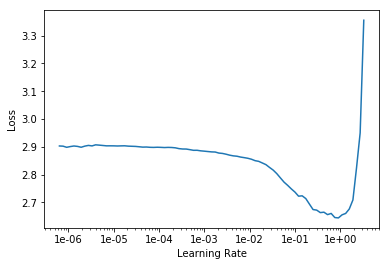

In [124]:
learn.lr_find()
learn.recorder.plot()

In [149]:
learn.fit(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,2.104358,2.045037,0.305672,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


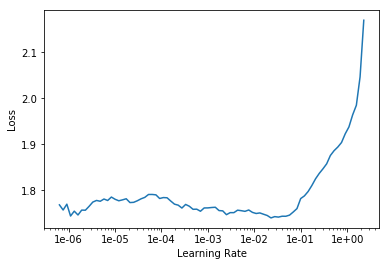

In [150]:
learn.lr_find()
learn.recorder.plot()

In [151]:
learn.fit(1,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.670778,2.003628,0.334925,00:03


In [152]:
learn.export("mbti_dist")

In [153]:
txt = """

FOX
82°

News
Weather
Only on FOX 4
Sports
About Us
More 
12 people killed in Virginia Beach shooting, police say
12 people killed in Virginia Beach shooting, police say
11 people killed in Virginia Beach shooting, police say
Active shooter reported at Virginia Beach courthouse
By fox5dc.com staff
Posted May 31 2019 03:57PM CDT

Video Posted May 31 2019 09:08PM CDT

Updated May 31 2019 09:09PM CDT

VIRGINIA BEACH, Va. (FOX 5 DC) - Twelve people were killed in a shooting at the Virginia Beach municipal center on Friday.

The suspect is also dead, and several other people were injured, according to police. 

CONTINUE READING BELOW
The Wall Street Journal reports the suspect is DeWayne Craddock, 40. 

Image Gallery 2 PHOTOS
 
Police say Craddock opened fire indiscriminately around 4 p.m.

Police Chief James Cervera said Craddock opened fire and shot "indiscriminately" at workers inside an operations building in the facility.

Cervera said police returned fire, killing Craddock. He said Craddock was a longtime employee of the city's Public Works Department. One of the people shot is a police officer.

Gov. Ralph Northam offered a statement Friday evening: 

“This is a horrific day for the Commonwealth of Virginia. We are devastated by the tragic shooting in Virginia Beach. I am in Virginia Beach with law enforcement authorities and Mayor Dyer, where I am monitoring the situation and offer the state’s full support.

My deepest condolences and prayers go to the families of those who left home this morning, and will not return tonight, as well as those who have been injured in this tragedy.

This is unspeakable, senseless violence. I commend local and state law enforcement, first responders, medical teams, and all others who acted swiftly to respond to this situation. My thoughts continue to be with the victims and their families.”

Maryland's Gov. Larry Hogan also released a statement: 

"Shocked and horrified by this heinous shooting in Virginia Beach. Our prayers are with the loved ones of the victims, all those who were injured, and with the selfless first responders. Maryland stands ready to offer any support needed."

The Associated Press contributed to this report.


More U.S. & World Stories
A Tennessee man has been sentenced to 10 months in prison for urinating on a Kellogg’s cereal conveyor belt at a Memphis facility.
Man sentenced to prison for urinating in Memphis cereal factory
By Associated Press
Posted May 31 2019 06:50PM CDT

Updated May 31 2019 08:16PM CDT

A Tennessee man has been sentenced to 10 months in prison for urinating on a Kellogg’s cereal conveyor belt at a Memphis facility.

The U.S. attorney’s office in Memphis says 49-year-old Gregory Stanton was sentenced Friday in federal court. Stanton had pleaded guilty in November to tampering with consumer products.

An indictment says Stanton was a contract worker at the Kellogg’s plant in April 2014 when he recorded a video of himself urinating into a bucket and dumping the contents into the Raisin Bran production line. He also recorded himself urinating into a production line a month later.

Read the full article 
A 2-year-old girl in Pennsylvania was revived with Narcan by officers after she was found unconscious.
2-year-old girl revived with Narcan after officer pulls bag out of child's mouth
By Kelly Taylor Hayes
Posted May 31 2019 03:12PM CDT

Updated May 31 2019 04:47PM CDT

A 2-year-old girl in Pennsylvania was revived with Narcan by officers after she was found unconscious.

Officers were called to a “child in distress” around 12:30 p.m. Friday outside of a store in Norristown, a suburb of Philadelphia.

Surveillance video shows a woman placing the girl on the sidewalk. A witness told FOX 29 he stopped to help and pulled a bag out of her mouth while attempting to revive her.

Read the full article 
Shannon Murray reports.
National Spelling Bee ends in 8-way tie, 3 champs from North Texas
By BEN NUCKOLS, Associated Press
Posted May 30 2019 09:14AM CDT

Updated May 31 2019 03:06PM CDT

OXON HILL, Md. (AP) - There were warning signs throughout a marathon day of spelling that this Scripps National Spelling Bee would not conclude like any other in the event's 94-year history.

Rishik Gandharsi sensed it as he stepped to the microphone for the ninth round of Thursday night's prime-time finals, when he was one of eight spellers remaining onstage.

"Just out of curiosity," Rishik asked pronouncer Jacques Bailly, "do you happen to know what time it is?"

Read the full article 
Featured Videos
Man sentenced to prison for urinating in Memphis cereal factory
Dallas PD in 'triage mode' after 40 May murders
How will new Mexican tariffs impact North Texas businesses?
12 people killed in Virginia Beach shooting, police say
Watch more videos
Most Recent
 
How will new Mexican tariffs impact North Texas businesses?
 
12 people killed in Virginia Beach shooting, police say
 
Dallas Zoo's baby hippo to make public debut this weekend
 
Bag with human remains of child found in Maleah Davis search in Arkansas
More Stories
Sponsored Stories:
NEWS
Local
Texas
US & World
Politics
Business
Consumer
Health
WEATHER
7-Day Forecast
Allergies
Alerts
Closings
4 Your Safety
Share Photos
ONLY ON FOX 4
Good Day
FOX 4 Features
Lone Star Adventures
Trackdown
Investigations
Basic Training Podcast
SPORTS
Cowboys
Mavericks
Rangers
Stars
FC Dallas
Colleges
High School
ABOUT US
Contact Us
Links from On Air
Anchors and Reporters
TV Listings
Station History
FAQ
Work For Us
Live Video Traffic Contests FOX 4 More
Follow Us
 
 
 
 
 
FOX 4 News App
Download on the App Store Get it on Google Play
FOX 4 WAPP
Download on the App Store Get it on Google Play
FOX 4 Fastlane
Download on the App Store Get it on Google Play
Updated Privacy Policy (What's Changed) Terms of Service Ad Choices FCC Public File EEOC Public File
"""
print(learn.predict(pd.DataFrame([get_distribution(txt)])))
rf.predict([get_distribution(txt)])

(Category ESFP, tensor(5), tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


array(['INFP'], dtype=object)

In [66]:
Y2 = [str(learn.predict(df.iloc[i])[0]) for i in range(7000, 8675)]

In [68]:
Y2[0:5]

['INFP', 'INTP', 'INFP', 'INFP', 'INFP']

In [69]:
set(Y2)

{'ENFP', 'ENTP', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP', 'ISTP'}

In [70]:
Y3 = df['Y'].iloc[7000:8675]

In [72]:
f1_score(Y2,Y3,average="micro")

0.328955223880597

In [73]:
learn.predict(df.iloc[8000])

(Category INFJ,
 tensor(8),
 tensor([0.0221, 0.0661, 0.0403, 0.0526, 0.0067, 0.0066, 0.0089, 0.0102, 0.2868,
         0.1234, 0.1938, 0.1022, 0.0172, 0.0215, 0.0205, 0.0212]))

In [75]:
learn.predict(df.iloc[7000])

(Category INFP,
 tensor(9),
 tensor([1.4520e-02, 4.4032e-02, 9.8339e-04, 4.2091e-03, 1.2192e-03, 1.0254e-03,
         3.4316e-04, 5.9594e-04, 1.1136e-01, 7.4701e-01, 1.4696e-02, 1.8259e-02,
         1.1601e-02, 2.2508e-02, 3.6701e-03, 3.9670e-03]))